# Predictive Model

## 1. Introduction
- Brief overview of the notebook's purpose and goals

In [1]:
import sys
import json
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

## 2. Data Generation
- Calculate the total debts from all lenders over time
- Generating a dataset with new date features such as 'day', 'month', 'year', 'quarter', 'dayofweek', and 'dayofyear'. The resulting DataFrame is saved as a CSV file named 'date_smedebtsu.csv'
- Generating a dataset with lagged features such as 'total_debts_lag1' and 'total_debts_lag2'. The resulting DataFrame is saved as a CSV file named 'lag_smedebtsu.csv' 


In [2]:
%run -i "../src/data_generation.py"

File saved successfully!
File path:  C:\Users\Admin\Desktop\Code\Coding_Interview\data/features\date_smedebtsu.csv
File saved successfully!
File path:  C:\Users\Admin\Desktop\Code\Coding_Interview\data/features\lag_smedebtsu.csv


In [3]:
# Show the generated dataset
date_debts = pd.read_csv("../data/features/date_smedebtsu.csv")
date_debts.head()

,date,total_debts,day,month,year,quarter,dayofweek,dayofyear
0,2013-10-13,228007.01,13,10,2013,4,6,286
1,2013-11-13,227988.31,13,11,2013,4,2,317
2,2013-12-10,265199.00,10,12,2013,4,1,344
3,2014-01-23,299453.00,23,1,2014,1,3,23
4,2014-03-05,290103.00,5,3,2014,1,2,64


In [4]:
# Show the generated dataset
date_debts = pd.read_csv("../data/features/lag_smedebtsu.csv")
date_debts.head()

,date,total_debts,total_debts_lag1,total_debts_lag2
0,2013-12-10,265199.0,227988.31,228007.01
1,2014-01-23,299453.0,265199.00,227988.31
2,2014-03-05,290103.0,299453.00,265199.00
3,2014-04-05,304337.0,290103.00,299453.00
4,2014-05-05,293623.0,304337.00,290103.00


## 3. Forecasting using Statistical Models
-  Statistical models, such as Autoregressive (AR), Moving Average (MA), and Autoregressive Integrated Moving Average (ARIMA), are commonly employed for forecasting

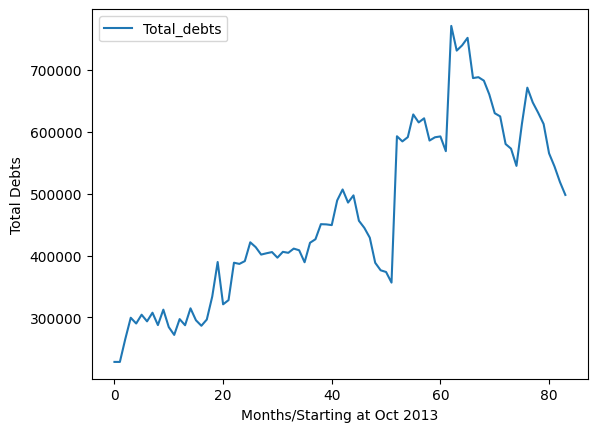

In [5]:
# We focus on the month of the year and the total debts. Plot a graph
processed_data_path = "../data/processed/processed_smedebtsu.csv"
df = pd.read_csv(processed_data_path)
# df['Date_time'] = pd.to_datetime(df['Date_time'])
df['Total_debts'] = df.sum(axis=1, numeric_only=True)
df_total_debts = df[['Date_time', 'Total_debts']]
df_total_debts.plot()

plt.xlabel("Months/Starting at Oct 2013")
plt.ylabel("Total Debts")
plt.show()

### Time-series decomposition

- Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

- Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

In [6]:
# let's find seasonal decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['Total_debts'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the components 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the components 
    debts_trend = result_decom.trend
    debts_season = result_decom.seasonal
    debts_resid = result_decom.resid
    return debts_trend, debts_season, debts_resid

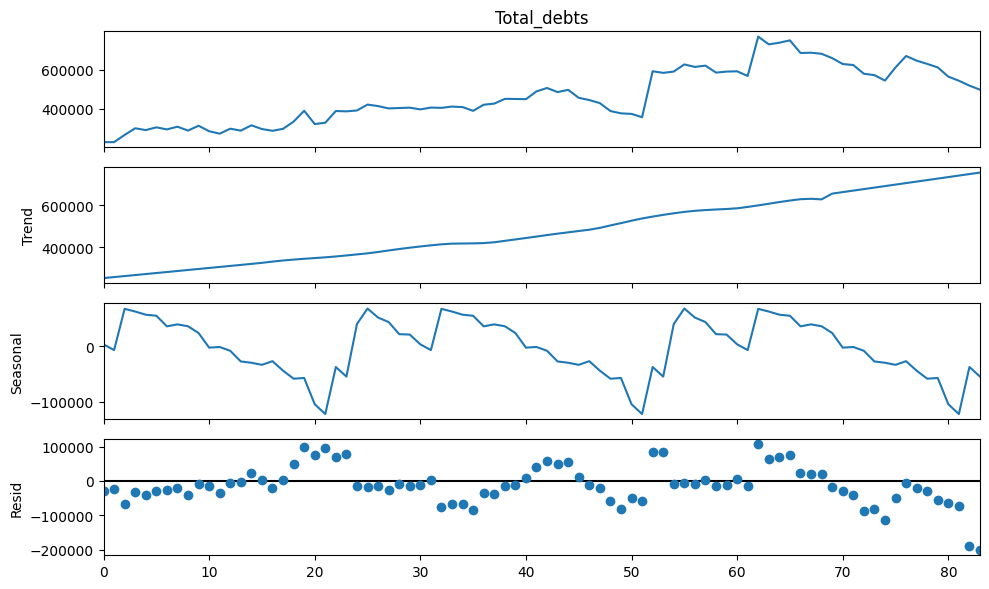

In [7]:
# let's find the components for Total_debts
# Period = 30 months
debts_trend, debts_season, debts_resid = decomposition(df_total_debts, period=30)

### Plot the autocorrelation and partial auto-correlation

In [8]:
# function to return ACF and PACF plots
def plot_acf_pacf(df, lags):
    var = df['Total_debts']
    # plot the ACF 
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()

    # plot the PACF
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

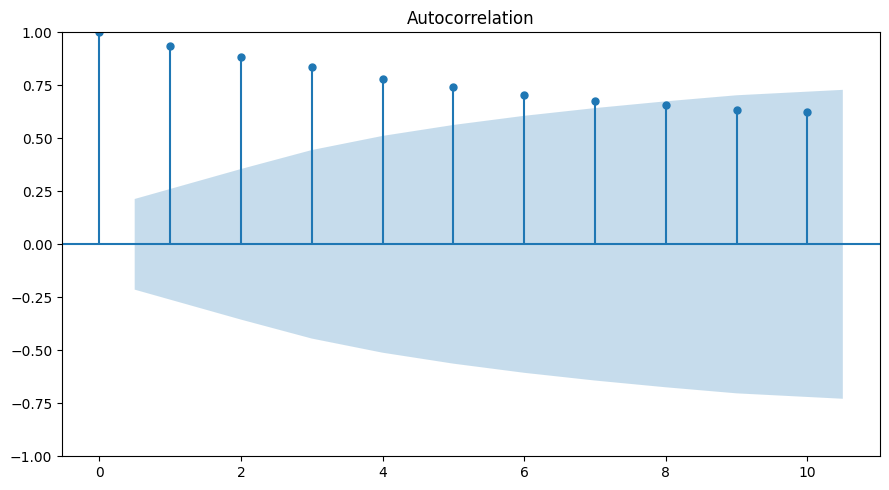

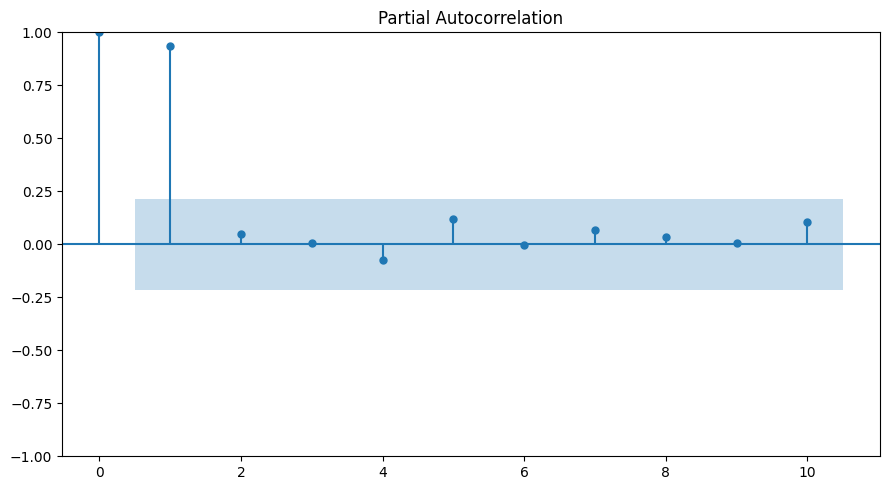

In [9]:
# Plot ACF and PACF of Total_debts
plot_acf_pacf(df_total_debts, lags=10)

- **Auto-correlation interpretation**: A slow decline in auto-correlation indicates time-series not stationary, we can prove the stationary of time series by **Dicky-fuller test**

- **Partical auto-correlation interpretation interpretation**: The graph indicates that the correlation between consecutive data points can only be effectively measured with a lag of one, as it is more significant compared to other lagged time-series.

### Dicky-Fuller Test (Stationary test)
- We will use "Dickey-Fuller test" to determine stationary.
- Hypothesis to prove Dicky-Fuller Test:
 - H0 - The time-series data is non-stationary
 - H1 - The time-series data is stationary

In [10]:
 def ADF_test(df):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(df['Total_debts'], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [11]:
ADF_test(df_total_debts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.892313
p-value                         0.335686
Lags Used                       0.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


- **Dicky-Fuller Test interpretation**: We can see p-value are much greater than 0.05, so the time-series data cannot reject H0. Therefore, the time-series data is not stationary

### Finding degree of differencing

In [12]:
def find_degree_of_differencing(df):
    # Perform ADF test to determine stationarity
    result = adfuller(df['Total_debts'])
    p_value = result[1]
    
    if p_value < 0.05:
        # Data is stationary, no differencing needed
        debts_ndiffs = 0
    else:
        # Increment differencing until data becomes stationary
        debts_ndiffs = 0
        while p_value >= 0.05:
            differenced_data = df['Total_debts'].diff().dropna()
            result = adfuller(differenced_data)
            p_value = result[1]
            debts_ndiffs += 1
    
    print(f"The degree of differencing is {debts_ndiffs} for 'Total_debts'.")

In [13]:
find_degree_of_differencing(df_total_debts)

The degree of differencing is 1 for 'Total_debts'.


### Train forecasting models using Auto-ARIMA

- **ARIMA (AutoRegressive Integrated Moving Average)** is a forecasting model used to predict future values of a time series, such as total debts, by considering the relationship between the observations, differencing the data, and incorporating the impact of past forecast errors. Here's how you can apply ARIMA for forecasting total debts:

- **Auto Regression (AR)**:
In the AR component of ARIMA, you analyze how the total debts at a given time depend on its own past values. You can identify the appropriate lag order, denoted as 'p', by examining the autocorrelation function (ACF) plot of the total debts time series. This helps determine the number of lagged values to include in the model.

- **Integration (I)**:
The integration component of ARIMA focuses on making the total debts time series stationary. Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. You can achieve stationarity by differencing the raw total debts observations. The differencing order, denoted as 'd', represents the number of times you need to difference the data to achieve stationarity.

- **Moving Average (MA)**:
The MA component of ARIMA takes into account the dependency between an observation and the residual errors from a moving average model applied to lagged observations. The order of the moving average component, denoted as 'q', determines the number of lagged forecast errors to include in the model.

In [14]:
# Split data into train and test sets using a specific day '2020-12-10'. 
# This ensures that the results can be compared with other methods using the same test set

df_total_debts['Date_time'] = pd.to_datetime(df_total_debts['Date_time'])

def split_arima(df):
    boundary_idx_test = '2020-12-10'
    train_df = df[df['Date_time'] < boundary_idx_test]
    test_df = df[df['Date_time'] >= boundary_idx_test]
    
    print("--------------Total Debts-----------------")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    
    return train_df, test_df

train_df, test_df = split_arima(df_total_debts)

--------------Total Debts-----------------
Train Size: 64, Test Size: 20


- We perform a grid search over a range of parameters for ARIMA models. We iterate through all combinations of parameters and fit an SARIMAX model using statsmodels. We keep track of the model with the lowest AIC (Akaike Information Criterion) as the best model. 

In [15]:
def find_best_fit_arima(df):
    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

model_arima_debts = find_best_fit_arima(train_df['Total_debts'])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=1498.428, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=1526.757, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=1502.418, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=1507.945, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=1531.776, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[3] intercept   : AIC=1505.027, Time=0.04 sec
 ARIMA(1,0,1)(1,1,1)[3] intercept   : AIC=1498.627, Time=0.13 sec
 ARIMA(1,0,1)(0,1,2)[3] intercept   : AIC=1497.044, Time=0.08 sec
 ARIMA(1,0,1)(1,1,2)[3] intercept   : AIC=1498.979, Time=0.14 sec
 ARIMA(0,0,1)(0,1,2)[3] intercept   : AIC=1506.742, Time=0.05 sec
 ARIMA(1,0,0)(0,1,2)[3] intercept   : AIC=1494.604, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[3] intercept   : AIC=1495.942, Time=0.04 sec
 ARIMA(1,0,0)(1,1,2)[3] intercept   : AIC=1496.596, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=1496.531, Time=0.11 sec
 ARIMA(0,0,0)(0,1,2)[3] intercept

In [16]:
model_arima_debts

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 2, 3),
      suppress_warnings=True)

- **Model ARIMA interpretation**: We will choose the best model ARIMA with the lowest AIC (Akaike Information Criterion) ARIMA (1,0,0)(0,1,2)[3]

### Forecasting on test data/ Calculating RMSE/ Visulization true values and predicted values

In [17]:
def plot_predictions(train_values, test_values, predicted_values, lower_confidence, upper_confidence):
    plt.figure(figsize=(10, 6))
    plt.plot(train_values.index, train_values, label='Train Values')
    plt.plot(test_values.index, test_values, label='Test Values')
    plt.plot(predicted_values.index, predicted_values, color='red', label='Predicted Values')
    plt.fill_between(lower_confidence.index, lower_confidence, upper_confidence, color='gray', alpha=0.3, label='Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Total Debts')
    plt.title('Total Debts: Train, Predicted, and True Values with Confidence Interval')
    plt.legend()
    plt.show()

In [18]:
def make_predictions_and_print_rmse(model, test_df):
    print(f"forecasting and RMSE of total debts")
    
    forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)
    forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)
    
    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))
    
    print("RMSE is: ", rmse)
    
    return forecasts, lower, upper

forecast_values, lower_confidence, upper_confidence = make_predictions_and_print_rmse(model_arima_debts, test_df['Total_debts'])

forecasting and RMSE of total debts
RMSE is:  154249.19718203467


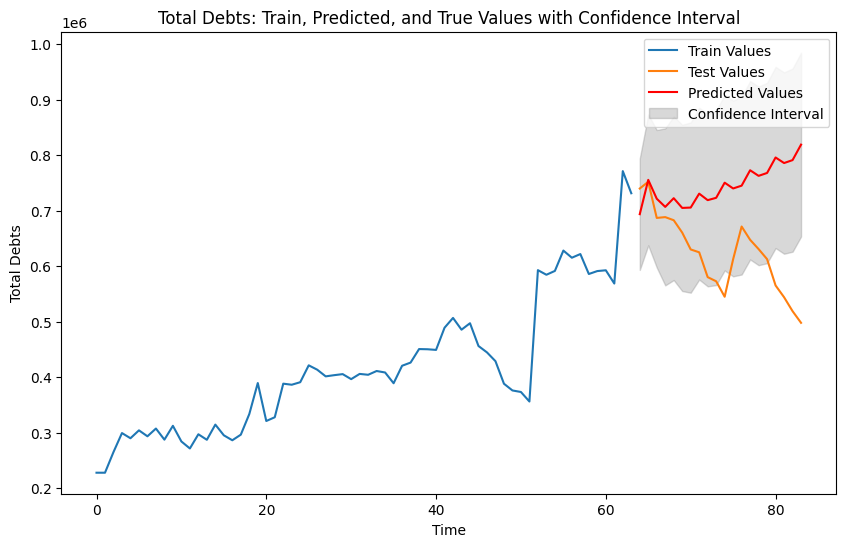

In [19]:
# Assuming you have the true values in a DataFrame named 'true_values'
train_values = train_df['Total_debts']
test_values = test_df['Total_debts']
# Plotting the predicted values, true values, and confidence interval
plot_predictions(train_values, test_values, forecast_values, lower_confidence, upper_confidence)

- **Result interpretation**: It is observed that the forecasting of ARIMA model tends to deviate from the actual values. The difference can be attributed to the underlying trend of the data. As the historical data exhibits an upward trend, the ARIMA model tends to project a continuation of this trend into the future.

## 4. Run Base Machine Learning Regressor Models
- This study aims to predict total debts using machine learning regressor models, including Linear Regression, XGBoost, and LightGBM. By employing these models, we seek to enhance the accuracy of total debt predictions and identify the most effective approach. Through the analysis of historical total debt data and the utilization of advanced machine learning techniques, we anticipate providing valuable insights into the prediction of future total debts, contributing to improved financial decision-making and risk management strategies.

- **The steps are implemented:**
1. **Split data use time-series cross validation**: In time series cross-validation, the dataset is split into multiple folds based on time. I use the rolling window approach, a fixed-size training window is moved forward in time, and at each step, a model is trained on the data within the window and evaluated on the subsequent period (test set).

![cross_validation.png](../documents/images/cross_validation.png)

2. **Run Machine Learning Regressor Models**: In time series cross-validation, each fold represents a distinct period in the time series data. When running machine learning regressors on each fold, the goal is to train the model on the historical data within the training set and evaluate its performance on the subsequent period (test set).

3. **Model evaluation**: Once the model is trained, it is evaluated on the validation set. The performance metrics, such as mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), and R2 score (R2_score).

4. **Results Structure**: The results from each fold are collected and calculated the mean of metrics across all folds for each regression algorithms, which analyzes to understand the overall performance of the machine learning regressors. Save the results into **"ML_regression_models"**

In [20]:
# Run the main model
%run -i "../src/demo_run_base_regressor_models.py"

2023-05-16 16:39:59.841352  File 0: date_smedebtsu.csv
2023-05-16 16:40:01.341340  File 1: lag_smedebtsu.csv


### Visualize predicted results

#### Dataset: "date_smedebtsu"

In [21]:
date_results_path = "../results/date_smedebtsu/ML_regression_models/average_results.json"
with open(date_results_path) as f:
    results = json.load(f)

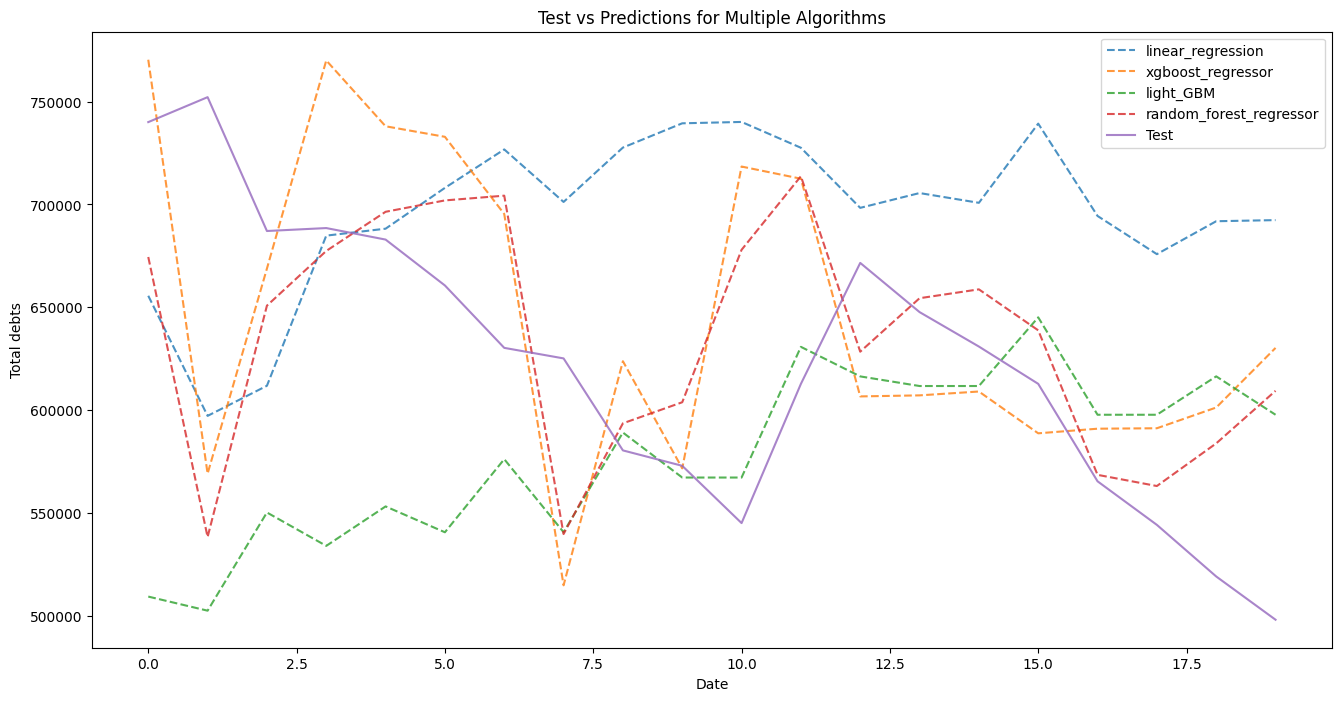

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(16, 8))

# Iterate over each algorithm's results
for result in results:
    algorithm = result["model"]
    predictions = result["prediction"]

    # Plot the predictions
    sns.lineplot(data=predictions, label=algorithm, linestyle='dashed', alpha=0.8)

# Plot the test values
sns.lineplot(data=results[0]["test"], label="Test", alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Total debts")
plt.title("Test vs Predictions for Multiple Algorithms")
plt.legend()
# Display the plot
plt.show()

**Result interpretation**: Based on the analysis of the test and prediction results, we observe that the Linear Regression and Light GBM algorithms show a significant deviation from the trend of the "total_debts" label. However, the Random Forest Regressor and XGBoost Regressor algorithms demonstrate a closer approximation to the underlying trend. These findings suggest that the Random Forest Regressor and XGBoost Regressor models may be more suitable for predicting the "total_debts" based on the available features

#### Dataset: "lag_smedebtsu"

In [23]:
date_results_path = "../results/lag_smedebtsu/ML_regression_models/average_results.json"
with open(date_results_path) as f:
    results = json.load(f)

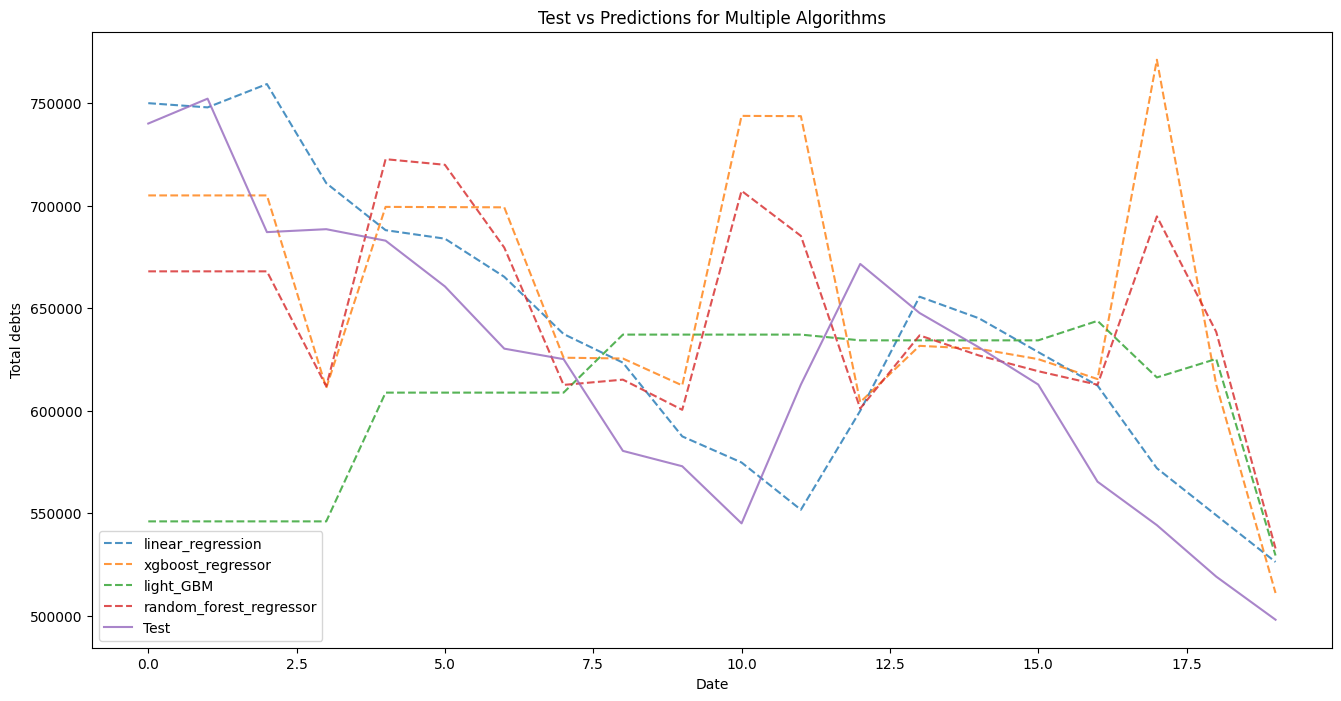

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(16, 8))

# Iterate over each algorithm's results
for result in results:
    algorithm = result["model"]
    predictions = result["prediction"]

    # Plot the predictions
    sns.lineplot(data=predictions, label=algorithm, linestyle='dashed', alpha=0.8)

# Plot the test values
sns.lineplot(data=results[0]["test"], label="Test", alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Total debts")
plt.title("Test vs Predictions for Multiple Algorithms")
plt.legend()
# Display the plot
plt.show()

**Result interpretation**

## 5. Train forecasting models using LSTM model

**The steps are implemented:**

1. Split data into train/ validation/ test using a specific day '2020-12-10'. 
2. Building model
3. Evaluation test sets use MAE, MSE, RMSE, R2_score metrics and then save results into **"DL_models"**
4. Visualization the predictions and ground truth

In [25]:
# Run the main model
%run -i "../src/demo_run_DL_model.py"

2023-05-16 16:40:07.205126  File 0: date_smedebtsu.csv
The number of training samples:  51
The number of validation samples:  13
The number of testing samples:  20
Starting training...
Epoch 1/10
4/4 [==============================] - 4s 247ms/step - loss: 0.0628 - mean_absolute_error: 0.2147 - val_loss: 0.3339 - val_mean_absolute_error: 0.5534
Epoch 2/10
4/4 [==============================] - 0s 16ms/step - loss: 0.0267 - mean_absolute_error: 0.1352 - val_loss: 0.2085 - val_mean_absolute_error: 0.4280
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 0.0178 - mean_absolute_error: 0.1082 - val_loss: 0.1382 - val_mean_absolute_error: 0.3486
Epoch 4/10
4/4 [==============================] - 0s 18ms/step - loss: 0.0220 - mean_absolute_error: 0.1161 - val_loss: 0.1617 - val_mean_absolute_error: 0.3776
Epoch 5/10
4/4 [==============================] - 0s 18ms/step - loss: 0.0173 - mean_absolute_error: 0.1066 - val_loss: 0.2030 - val_mean_absolute_error: 0.4227
Epoch 6/1

### Visualize predicted results
#### Dataset: "date_smedebtsu"

In [26]:
date_results_path = "../results/date_smedebtsu/DL_models/average_results.json"
with open(date_results_path) as f:
    results = json.load(f)

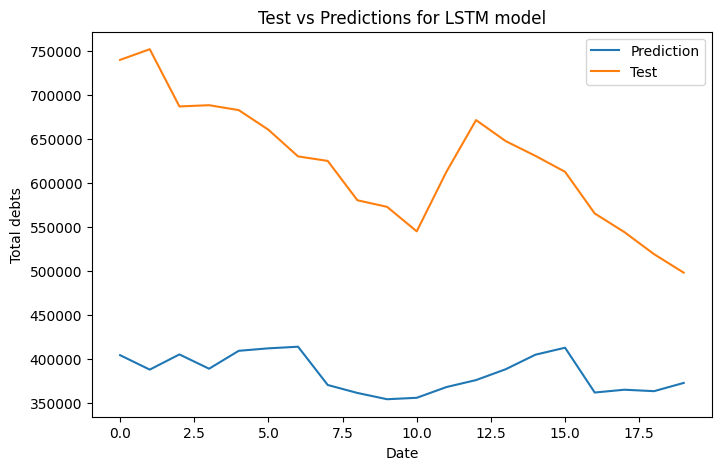

In [27]:
# Create a new figure
plt.figure(figsize=(8, 5))

# Plot the predictions
sns.lineplot(data=results['predictions'], label="Prediction")
# Plot the test values
sns.lineplot(data=results['target'], label="Test")

plt.xlabel("Date")
plt.ylabel("Total debts")
plt.title("Test vs Predictions for LSTM model")
plt.legend()
# Display the plot
plt.show()

#### Dataset: "lag_smedebtsu"

In [28]:
date_results_path = "../results/lag_smedebtsu/DL_models/average_results.json"
with open(date_results_path) as f:
    results = json.load(f)

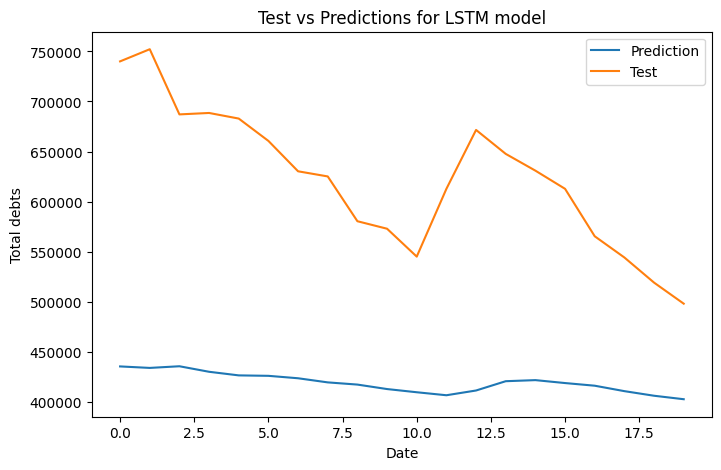

In [29]:
# Create a new figure
plt.figure(figsize=(8, 5))

# Plot the predictions
sns.lineplot(data=results['predictions'], label="Prediction")
# Plot the test values
sns.lineplot(data=results['target'], label="Test")

plt.xlabel("Date")
plt.ylabel("Total debts")
plt.title("Test vs Predictions for LSTM model")
plt.legend()
# Display the plot
plt.show()

## 6. Hypothesis 
- We use Friedmen test and Nemenyi test

In [30]:
def get_metric_files(result_path):
    rmse_benchmark = {
        'dataset': [],
        'LSTM': [],
        'linear_regression': [],
        'xgboost_regressor': [],
        'light_GBM': [],
        'random_forest_regressor': []
    }

    for dataset in os.listdir(result_path):
        dataset_path = os.path.join(result_path, dataset)
        for model_dir in os.listdir(dataset_path):
            file_path = os.path.join(dataset_path, model_dir, 'average_results.json')
            with open(file_path) as f:
                data = json.load(f)
                if model_dir == 'DL_models':
                    rmse_benchmark['dataset'].append(data['dataset'])
                    rmse_benchmark['LSTM'].append(data['RMSE'])
                elif model_dir == 'ML_regression_models':
                    for element in data:
                        model_name = element["model"]
                        if model_name in rmse_benchmark:
                            rmse_benchmark[model_name].append(element['mean_RMSE'])

    return rmse_benchmark

In [31]:
result_path = "../results/"
rmse_benchmark = get_metric_files(result_path)

In [32]:
# Get all RMSE metrics from other algorithms
rmse_benchmark_df = pd.DataFrame(rmse_benchmark)
rmse_benchmark_df

,dataset,LSTM,linear_regression,xgboost_regressor,light_GBM,random_forest_regressor
0,date_smedebtsu,246431.781042,111773.503881,81297.727978,85993.442301,70641.236397
1,lag_smedebtsu,212800.076612,34555.416457,74626.367183,76812.045530,67947.456083


### Friedmen test 

In [33]:
import numpy as np
from scipy.stats import friedmanchisquare

In [34]:
# Select only the model columns (excluding the 'dataset' column)
model_columns = df.columns[1:]

# Perform the Friedman test
statistic, p_value = friedmanchisquare(*[df[col] for col in model_columns])

# Print the results
print(f"Friedman test statistic: {statistic}")
print(f"P-value: {p_value}")

Friedman test statistic: 466.2888557257602
P-value: 4.903935769808447e-93
